# Lesson 2 - Image Classification Models from Scratch

In [ ]:
#Run once per session
!pip install fastai -q --upgrade

Grab our vision related libraries

In [ ]:
from fastai.vision.all import *

And our data

In [ ]:
path = untar_data(URLs.MNIST)

## Working with the data

In [ ]:
items = get_image_files(path)

In [ ]:
items[0]

PosixPath('/root/.fastai/data/mnist_png/training/0/12497.png')

Create an image object. Done automatically with `ImageBlock`.

In [ ]:
im = PILImageBW.create(items[0])

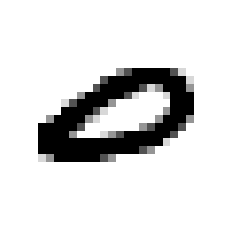

In [ ]:
im.show()

Split our data with `GrandparentSplitter`, which will make use of a `train` and `valid` folder.

In [ ]:
splits = GrandparentSplitter(train_name='training', valid_name='testing')

In [ ]:
items[:3]

(#3) [/root/.fastai/data/mnist_png/training/0/12497.png,/root/.fastai/data/mnist_png/training/0/5475.png,/root/.fastai/data/mnist_png/training/0/33023.png]

Splits need to be applied to some items

In [ ]:
splits = splits(items)

In [ ]:
splits[0][:5], splits[1][:5]

([0, 1, 2, 3, 4], [60000, 60001, 60002, 60003, 60004])

* Make a `Datasets`

* Expects items, transforms for describing our problem, and a splitting method

In [ ]:
dsrc = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]], 
                  splits=splits)

We can look at an item in our `Datasets` with `show_at`

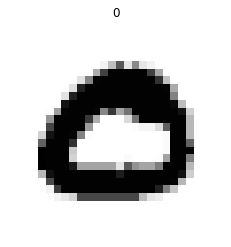

In [ ]:
show_at(dsrc.train, 3)

We can see that it's a `PILImage` of a zero, along with a label of `0`

Next we need to give ourselves some transforms on the data! These will need to:
1. Ensure our images are all the same size
2. Make sure our output are the `tensor` our models are wanting
3. Give some image augmentation

In [ ]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

* `ToTensor`: Converts to tensor
* `CropPad` and `RandomCrop`: Resizing transforms
* Applied on the `CPU` via `after_item`

In [ ]:
gpu_tfms = [IntToFloatTensor(), Normalize()]

* ``: Enables GPU usage
* `IntToFloatTensor`: Converts to a float
* `Normalize`: Normalizes data

In [ ]:
dls = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

And show a batch

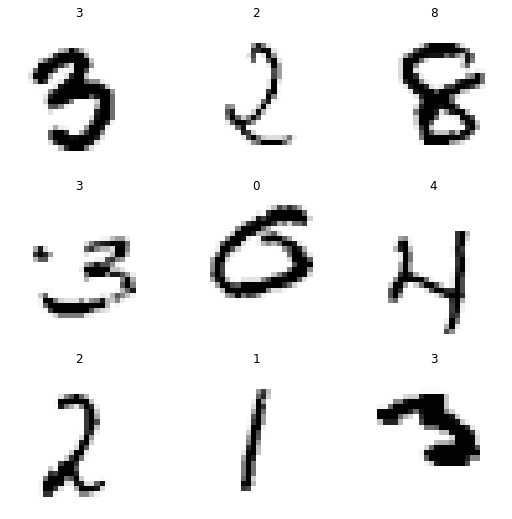

In [ ]:
dls.show_batch()

From here we need to see what our model will expect

In [ ]:
xb, yb = dls.one_batch()

And now the shapes:

In [ ]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
dls.c

10

So our input shape will be a [128 x 1 x 28 x 28] and our output shape will be a [128] tensor that we need to condense into 10 classes

## The Model

Our models are made up of **layers**, and each layer represents a matrix multiplication to end up with our final `y`. For this image problem, we will use a **Convolutional layer**, a **Batch Normalization layer**, an **Activation Function**, and a **Flattening layer**

### Convolutional Layer

These are always the first layer in our network. I will be borrowing an analogy from [here](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) by Adit Deshpande.

Our example Convolutional layer will be 5x5x1

Imagine a flashlight that is shining over the top left of an image, which covers a 5x5 section of pixels at one given moment. This flashlight then slides crosses our pixels at all areas in the picture. This flashlight is called a **filter**, which can also be called a **neuron** or **kernel**. The region it is currently looking over is called a **receptive field**. This filter is also an array of numbers called **weights** (or **parameters**). The depth of this filter **must** be the same as the depth of our input. In our case it is 1 (in a color image this is 3). Now once this filter begins moving (or **convolving**) around the image, it is multiplying the values inside this filter with the original pixel value of our image (also called **element wise multiplications**). These are then summed up (in our case this is just one multiplication of 28x28) to an individual value, which is a representation of **just** the top left of our image. Now repeat this until every unique location has a number and we will get what is called an **activation** or **feature map**. This feature map will be 784 different locations, which turns into a 28x28 array


In [ ]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

Here we can see our `ni` is equivalent to the depth of the filter, and `nf` is equivalent to how many filters we will be using. (Fun fact this always has to be divisible by the size of our image).

### Batch Normalization

As we send our tensors through our model, it is important to normalize our data throughout the network. Doing so can allow for a much larger improvement in training speed, along with allowing each layer to learn independantly (as each layer is then re-normalized according to it's outputs)

In [ ]:
def bn(nf): return nn.BatchNorm2d(nf)

`nf` will be the same as the filter output from our previous convolutional layer

### Activation functions

They give our models non-linearity and work with the `weights` we mentioned earlier along with a `bias` through a process called **back-propagation**. These allow our models to learn and perform more complex tasks because they can choose to fire or activate one of those neurons mentioned earlier. On a simple sense, let's look at the `ReLU` activation function. It operates by turning any negative values to zero, as visualized below:

![](https://miro.medium.com/max/2052/1*DfMRHwxY1gyyDmrIAd-gjQ.png)

From "A Practical Guide to ReLU by Danqing Liu [URL](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7).

In [ ]:
def ReLU(): return nn.ReLU(inplace=False)

### Flattening

The last bit we need to do is take all these activations and this outcoming matrix and flatten it into a single dimention of predictions. We do this with a `Flatten()` module

In [ ]:
Flatten??

# Making a Model

* Five convolutional layers
* `nn.Sequential`
* 1 -> 32 -> 10

In [ ]:
model = nn.Sequential(
    conv(1, 8),
    bn(8),
    ReLU(),
    conv(8, 16),
    bn(16),
    ReLU(),
    conv(16,32),
    bn(32),
    ReLU(),
    conv(32, 16),
    bn(16),
    ReLU(),
    conv(16, 10),
    bn(10),
    Flatten()
)

Now let's make our `Learner`

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

We can then also call `learn.summary` to take a look at all the sizes with thier **exact** output shapes

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 8 x 14 x 14    80         True      
________________________________________________________________
BatchNorm2d          128 x 8 x 14 x 14    16         True      
________________________________________________________________
ReLU                 128 x 8 x 14 x 14    0          False     
________________________________________________________________
Conv2d               128 x 16 x 7 x 7     1,168      True      
________________________________________________________________
BatchNorm2d          128 x 16 x 7 x 7     32         True      
________________________________________________________________
ReLU                 128 x 16 x 7 x 7     0          False     
________________________________________________________________
Conv2d               128 x 32 x 4 x 4     4,640      True      
______________________________________________________

`learn.summary` also tells us:
* Total parameters
* Trainable parameters
* Optimizer
* Loss function
* Applied `Callbacks`

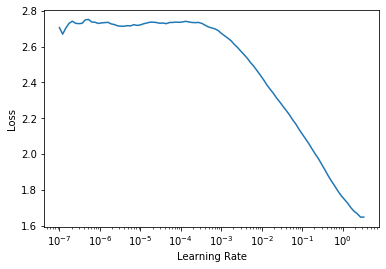

In [ ]:
learn.lr_find()

Let's use a learning rate around 1e-1 (0.1)

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.209175,0.159102,0.951200,01:14
1,0.123667,0.066494,0.978500,01:14
2,0.066589,0.038887,0.988300,01:14


# Simplify it

* Try to make it more like `ResNet`.
* `ConvLayer` contains a `Conv2d`, `BatchNorm2d`, and an activation function

In [ ]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

And make a new model

In [ ]:
net = nn.Sequential(
    conv2(1,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,10),
    Flatten()
)

Great! That looks much better to read! Let's make sure we get (roughly) the same results with it.

In [ ]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.220734,0.197168,0.933900,01:15
1,0.130333,0.075714,0.975800,01:14
2,0.078764,0.041104,0.987000,01:15


Almost the exact same! Perfect! Now let's get a bit more advanced

# ResNet (kinda)

The ResNet architecture is built with what are known as ResBlocks. Each of these blocks consist of two `ConvLayers` that we made before, where the number of filters do not change. Let's generate these layers. 

In [ ]:
class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)
  
  def forward(self, x): return x + self.conv2(self.conv1(x))

* Class notation
* `__init__`
* `foward`

Let's add these in between each of our `conv2` layers of that last model. 

In [ ]:
net = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

In [ ]:
net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

Awesome! We're building a pretty substantial model here. Let's try to make it **even simpler**. We know we call a convolutional layer before each `ResBlock` and they all have the same filters, so let's make that layer!

In [ ]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [ ]:
net = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

And now we have something that resembles a ResNet! Let's see how it performs

In [ ]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

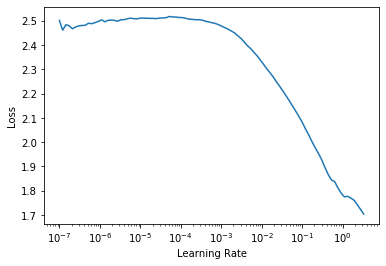

In [ ]:
learn.lr_find()

Let's do 1e-1 again

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.156825,0.904546,0.756200,01:16
1,0.089813,0.063087,0.980300,01:16
2,0.040906,0.025675,0.992200,01:18
